In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [2]:
nvdaX = pd.read_csv('nvdaDF-q2.csv')
nvdaX = nvdaX.loc[:, nvdaX.columns != 'date']
nvdaX = nvdaX.loc[:, nvdaX.columns != 'Unnamed: 0']
nvdaX = nvdaX.loc[:, nvdaX.columns != 'daychange']
nvdaX = nvdaX.loc[:, nvdaX.columns != 'anger']
nvdaX = nvdaX.loc[:, nvdaX.columns != 'disgust']
nvdaX = nvdaX.loc[:, nvdaX.columns != 'fear']
nvdaX = nvdaX.loc[:, nvdaX.columns != 'joy']
nvdaX = nvdaX.loc[:, nvdaX.columns != 'sadness']
nvdaX = nvdaX.loc[:, nvdaX.columns != 'surprise']
nvdaX = nvdaX.loc[:, nvdaX.columns != 'connectivity']
nvdaX = nvdaX.loc[:, nvdaX.columns != 'avgdeg']

nvdaX = nvdaX.head(70)
nvdaX

,size,edges,diameter,clustering,volume
0,304,246,10,0.000549,56064000
1,247,196,9,0.000000,32276000
2,243,187,8,0.001235,58042400
3,272,215,8,0.000760,46148000
4,217,180,8,0.001662,29252800
...,...,...,...,...,...
65,262,220,9,0.000000,24441600
66,207,182,7,0.000167,19517200
67,1064,1070,15,0.000214,86932400
68,1016,962,21,0.000561,67621200


<Axes: >

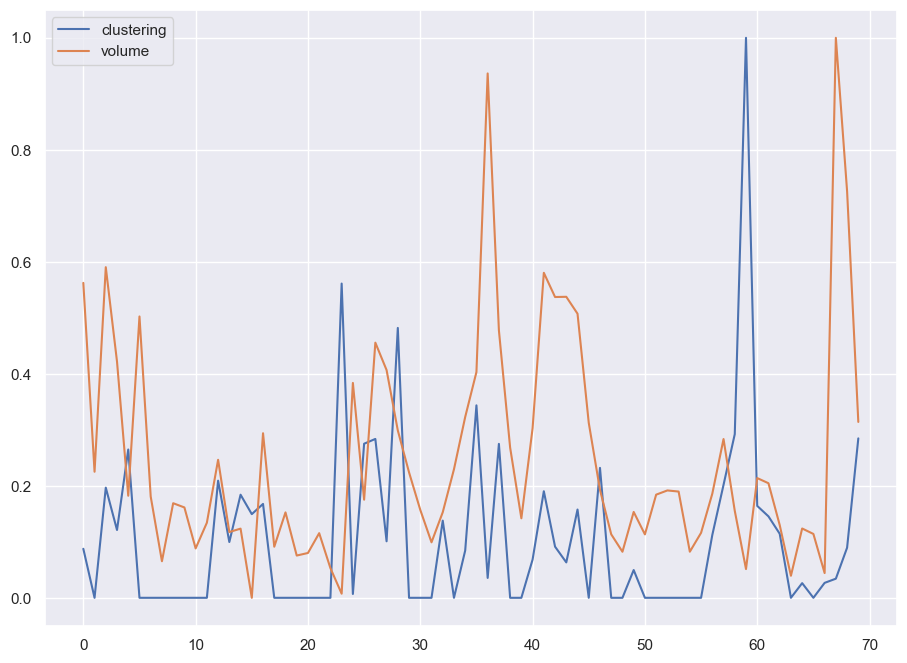

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sns.set(rc={'figure.figsize':(11,8)})

nvdaXs = scaler.fit_transform(nvdaX)
nvdaXs = pd.DataFrame(nvdaXs,columns=['size','edges','diameter','clustering','volume'])
nvdaXs[['clustering','volume']].plot()

In [4]:
for metric in nvdaXs.columns:
    result = adfuller(nvdaXs[[metric]])
    print('A-DF of metric',metric,'has p-value of',result[1])
    print()

A-DF of metric size has p-value of 2.652679982939173e-05

A-DF of metric edges has p-value of 1.81125019387206e-05

A-DF of metric diameter has p-value of 1.3985460792512441e-08

A-DF of metric clustering has p-value of 0.0002759067489761822

A-DF of metric volume has p-value of 1.1113441982113797e-05



In [6]:
#build the VAR model
model = VAR(nvdaXs)
print(model.select_order(5))

nvda_model = model.fit(1)

nvda_model.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 0, FPE -> 1, HQIC ->  1>


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Oct, 2023
Time:                     11:08:04
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -23.1121
Nobs:                     69.0000    HQIC:                  -23.6981
Log likelihood:           371.345    FPE:                3.48057e-11
AIC:                     -24.0834    Det(Omega_mle):     2.29398e-11
--------------------------------------------------------------------
Results for equation size
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.158417         0.058530            2.707           0.007
L1.size              -2.382002         1.319062           -1.806           0.071
L1.edges              2.964195         1.353316            2.

Text(0, 0.5, 'Volume (0,1)')

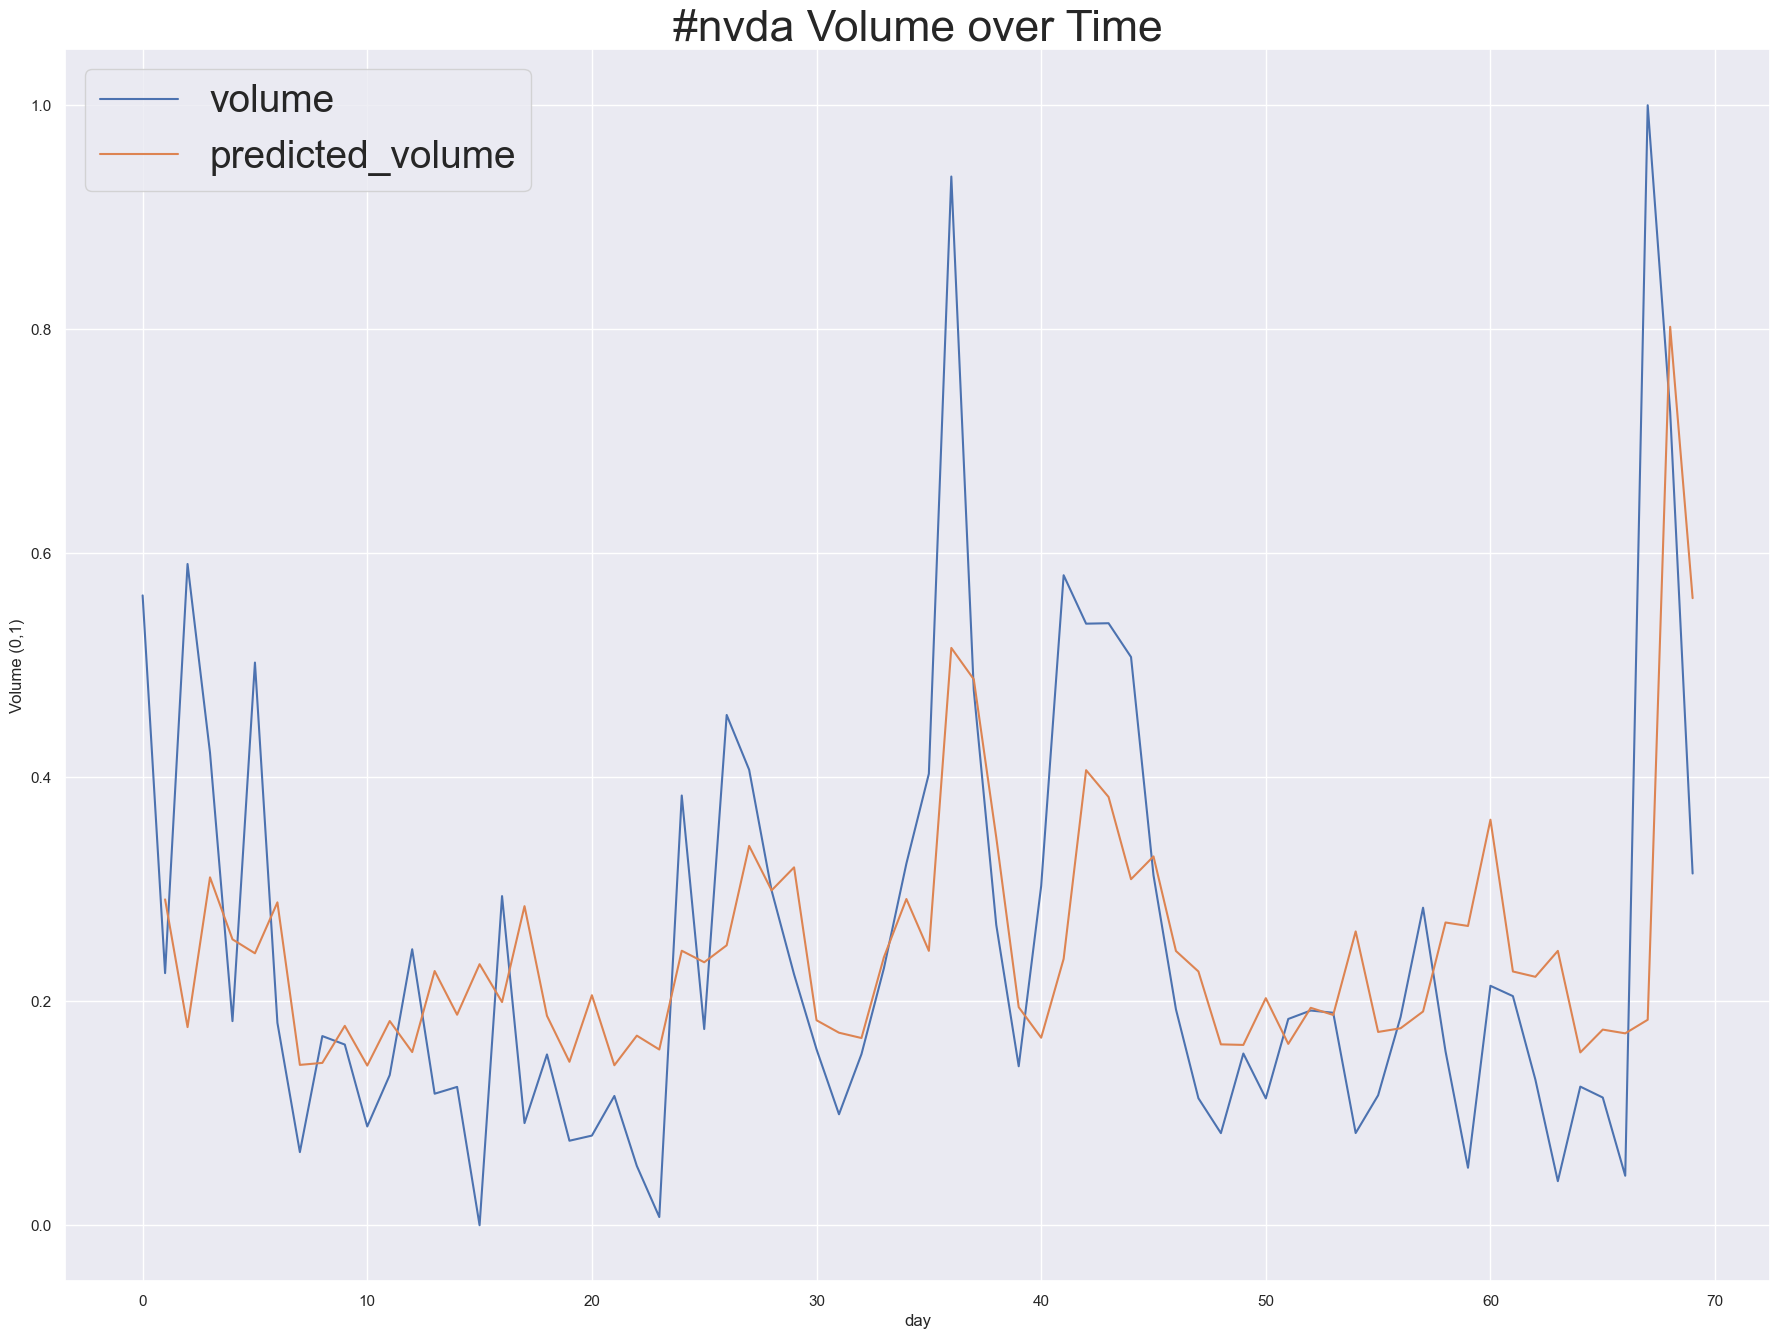

In [7]:
#forecast and plot

sns.set(rc={'figure.figsize':(22,16)})

nvdaXs[['volume']].plot()
plt.plot(nvda_model.fittedvalues['volume'],label='predicted_volume')
plt.legend(fontsize='28')
plt.title('#nvda Volume over Time',fontsize=32)
plt.xlabel('day')
plt.ylabel('Volume (0,1)')

In [8]:
#test for causality
print(nvda_model.test_causality(4,0))
print(nvda_model.test_causality(4,1))
print(nvda_model.test_causality(4,2))
print(nvda_model.test_causality(4,3))
print(nvda_model.test_causality(4,4))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: size does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 1.983, critical value: 3.871>, p-value: 0.160>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: edges does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 2.783, critical value: 3.871>, p-value: 0.096>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: diameter does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.093, critical value: 3.871>, p-value: 0.761>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: clustering does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 2.322, critical value: 3.871>, p-value: 0.129>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: volu

In [9]:
print('nvda',mean_absolute_error(nvdaXs[['volume']][1:],nvda_model.fittedvalues['volume']))

nvda 0.11371843558584702
